In [72]:
import numpy as np
import sklearn 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from latexify import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=100, noise=0.1)

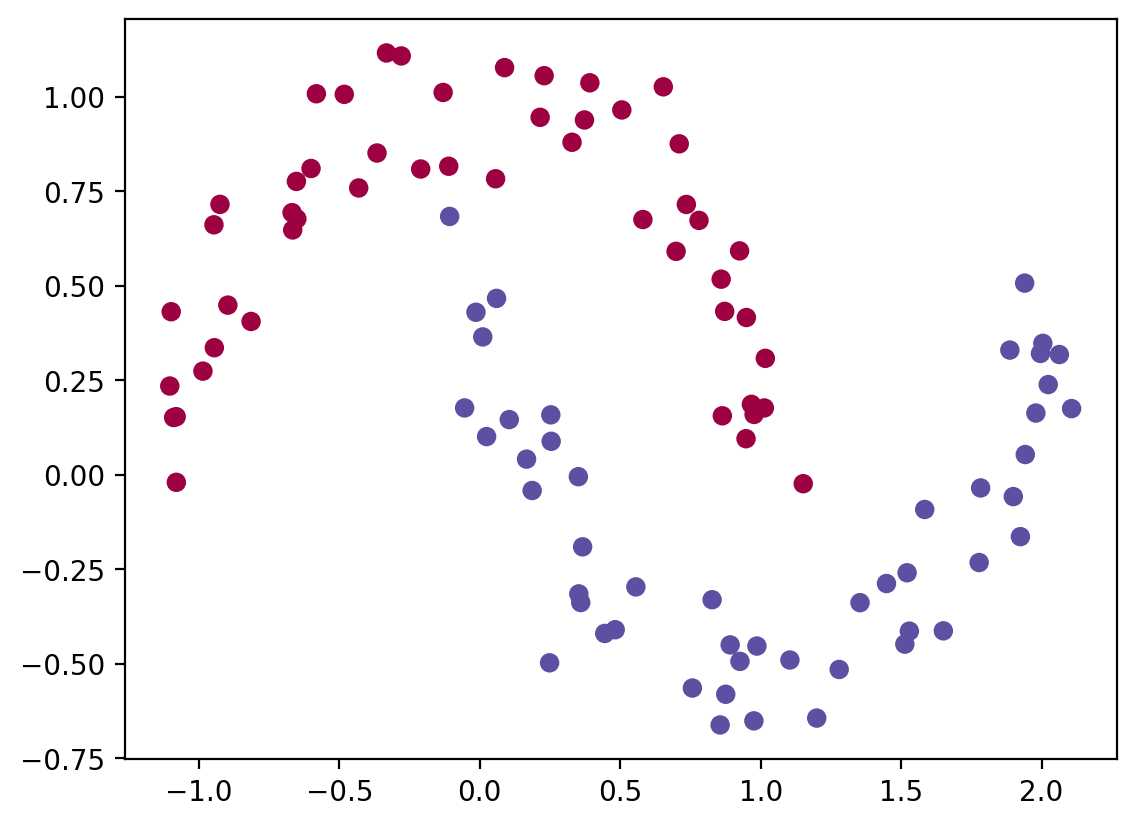

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [29]:
log_reg = LogisticRegression(2)

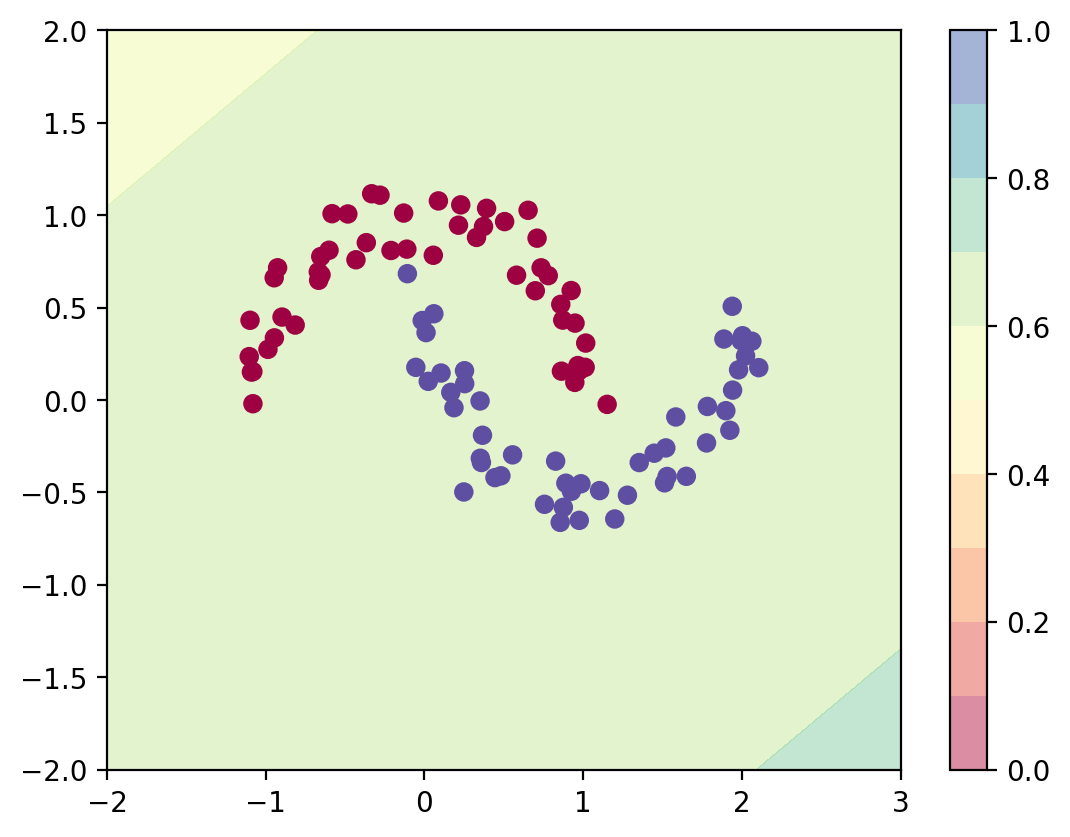

In [30]:
# Predict with the model

def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-2, 3, 100), torch.linspace(-2, 2, 100))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
predict_plot_grid(log_reg)
    
    

In [31]:


opt = torch.optim.Adam(log_reg.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt.zero_grad()
    logits = log_reg(torch.tensor(X, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, torch.tensor(y, dtype=torch.float32).view(-1, 1))
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


0 0.7104504108428955
10 0.6601136922836304
20 0.6153445243835449
30 0.576545000076294
40 0.5435934662818909
50 0.5159685015678406
60 0.4929444193840027
70 0.47375598549842834
80 0.45769837498664856
90 0.4441695511341095
100 0.4326764643192291
110 0.4228237569332123
120 0.41429755091667175
130 0.4068489968776703
140 0.40028053522109985
150 0.3944348096847534
160 0.389186292886734
170 0.38443419337272644
180 0.38009756803512573
190 0.3761110305786133
200 0.3724215626716614
210 0.36898621916770935
220 0.3657699525356293
230 0.36274418234825134
240 0.359885573387146
250 0.35717469453811646
260 0.3545958995819092
270 0.35213592648506165
280 0.3497839868068695
290 0.34753093123435974
300 0.3453693091869354
310 0.34329262375831604
320 0.34129542112350464
330 0.3393731713294983
340 0.3375217318534851
350 0.3357376456260681
360 0.33401787281036377
370 0.33235955238342285
380 0.33076024055480957
390 0.3292176127433777
400 0.32772961258888245
410 0.3262942135334015
420 0.3249095678329468
430 0.32

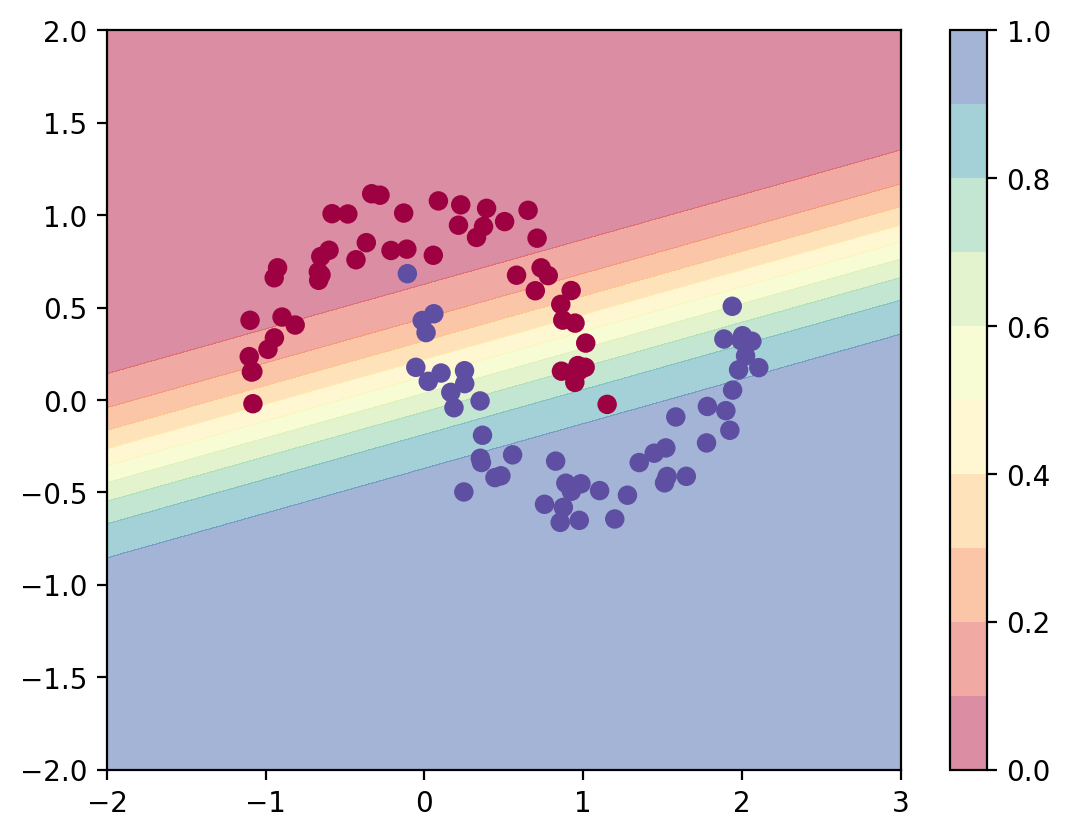

In [32]:
predict_plot_grid(log_reg)

In [33]:
# Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [36]:
X = iris.data
y = iris.target

Text(0, 0.5, 'Sepal width')

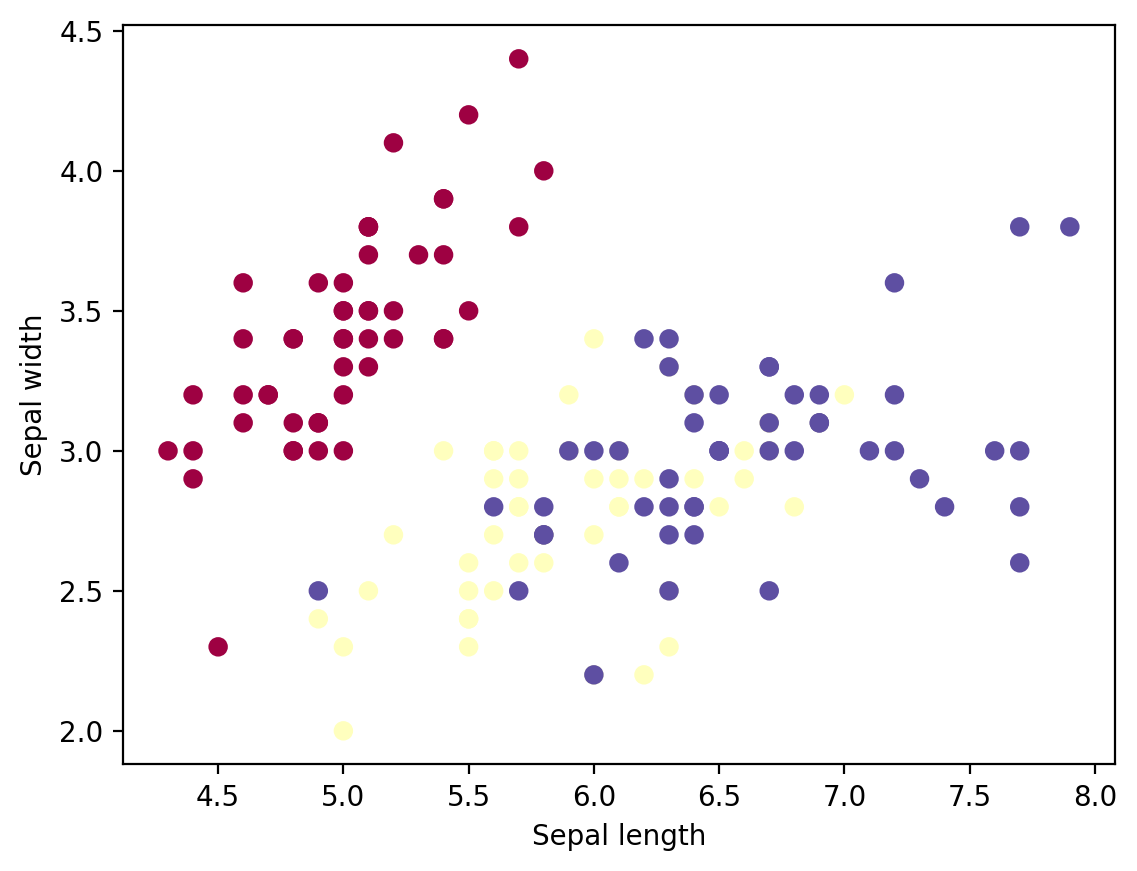

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [55]:
class ThreeClassLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(ThreeClassLogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, 1)
        self.linear2 = nn.Linear(input_dim, 1)
        self.linear3 = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits1 = self.linear1(x)
        logits2 = self.linear2(x)
        logits3 = self.linear3(x)
        return torch.cat([logits1, logits2, logits3], dim=-1)
    

class MultiClassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [52]:
mlr = ThreeClassLogisticRegression(2)

In [53]:
X_tensor = torch.tensor(X, dtype=torch.float32)[:,:2]
y_tensor = torch.tensor(y, dtype=torch.long)

In [54]:
mlr(X_tensor).shape

torch.Size([150, 3])

In [68]:
mlr_efficient = MultiClassLogisticRegression(2, 3)
mlr_efficient(X_tensor).shape

torch.Size([150, 3])

In [69]:
mlr_efficient(X_tensor[:5])

tensor([[-3.3458, -3.8345,  2.0866],
        [-3.1443, -3.5755,  1.8390],
        [-3.0622, -3.5652,  1.9337],
        [-2.9871, -3.4889,  1.8832],
        [-3.3047, -3.8293,  2.1339]], grad_fn=<AddmmBackward0>)

In [70]:

nn.Softmax(dim=-1)(mlr_efficient(X_tensor[:5])).sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [73]:
opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False
prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 3.6697728633880615
10 2.437390089035034
20 1.4345753192901611
30 1.0785937309265137
40 1.0964395999908447
50 1.0800353288650513
60 1.0474778413772583
70 1.0362906455993652
80 1.0254629850387573
90 1.0132005214691162
100 1.0019069910049438
110 0.9902804493904114
120 0.978620171546936
130 0.9669626951217651
140 0.9553221464157104
150 0.9437591433525085
160 0.9323036670684814
170 0.9209904074668884
180 0.9098463654518127
190 0.8988940715789795
200 0.8881524801254272
210 0.8776363134384155
220 0.8673567771911621
230 0.8573226928710938
240 0.8475399017333984
250 0.8380118012428284
260 0.8287402391433716
270 0.8197252154350281
280 0.8109650015830994
290 0.8024575710296631
300 0.7941986322402954
310 0.7861839532852173
320 0.7784084677696228
330 0.7708665132522583
340 0.7635519504547119
350 0.7564586997032166
360 0.7495799660682678
370 0.7429093718528748
380 0.7364398241043091
390 0.7301651239395142
400 0.7240780591964722
410 0.7181723713874817
420 0.7124415040016174
430 0.7068790793418884
4

In [75]:
mlr_efficient(X_tensor[:5])

tensor([[ 2.3140, -3.1311, -4.6368],
        [ 0.2948, -1.8215, -3.8700],
        [ 2.5609, -2.4203, -4.6945],
        [ 2.4696, -2.1745, -4.6521],
        [ 3.4470, -3.4305, -5.0490]], grad_fn=<AddmmBackward0>)

In [78]:
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()

In [79]:
import pandas as pd

In [80]:
df = pd.DataFrame(pred, columns=iris.target_names)
df["GT"] = iris.target
df

,setosa,versicolor,virginica,GT
0,0.994752,0.004295,0.000953,0
1,0.880279,0.106049,0.013672,0
2,0.992485,0.006814,0.000701,0
3,0.989682,0.009519,0.000799,0
4,0.998767,0.001029,0.000204,0
...,...,...,...,...
145,0.000135,0.310518,0.689347,2
146,0.000024,0.515373,0.484603,2
147,0.000496,0.381761,0.617743,2
148,0.094878,0.410096,0.495026,2


In [81]:
# Find prediction
y_pred = pred.argmax(axis=-1)

df["Predicted Class"] = y_pred


In [82]:
df

,setosa,versicolor,virginica,GT,Predicted Class
0,0.994752,0.004295,0.000953,0,0
1,0.880279,0.106049,0.013672,0,0
2,0.992485,0.006814,0.000701,0,0
3,0.989682,0.009519,0.000799,0,0
4,0.998767,0.001029,0.000204,0,0
...,...,...,...,...,...
145,0.000135,0.310518,0.689347,2,2
146,0.000024,0.515373,0.484603,2,1
147,0.000496,0.381761,0.617743,2,2
148,0.094878,0.410096,0.495026,2,2


In [83]:
# Accuracy
(y_pred == iris.target).mean()

0.8266666666666667

In [86]:
# Add more features like x^2, xy, y^2

X = iris.data
y = iris.target

X = np.concatenate([X, X**2, X[:, [0]]*X[:, [1]], X[:, [1]]**2], axis=-1)

X_tensor = torch.tensor(X, dtype=torch.float32)

mlr_efficient = MultiClassLogisticRegression(10, 3)


opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_tensor)
    loss = F.cross_entropy(logits, y_tensor)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1
    


0 4.386221408843994
10 1.3555710315704346
20 0.539000928401947
30 0.391224205493927
40 0.3121725618839264
50 0.27308228611946106
60 0.24870391190052032
70 0.22769100964069366
80 0.21121273934841156
90 0.19696174561977386
100 0.18461136519908905
110 0.17376990616321564
120 0.1641765683889389
130 0.15566210448741913
140 0.14806975424289703
150 0.1412755846977234
160 0.13517214357852936
170 0.12966902554035187
180 0.12468919157981873
190 0.1201673224568367
200 0.11604750156402588
210 0.11228205263614655
220 0.10883000493049622
230 0.10565614700317383
240 0.102729931473732
250 0.1000249832868576
260 0.09751836955547333
270 0.0951899066567421
280 0.09302214533090591
290 0.09099956601858139
300 0.0891086608171463
310 0.08733730763196945
320 0.08567488193511963
330 0.08411194384098053
340 0.08263996243476868
350 0.08125142008066177
360 0.0799395963549614
370 0.07869838923215866
380 0.07752230763435364
390 0.07640647143125534
400 0.07534641772508621
410 0.07433813065290451
420 0.07337787747383

In [87]:
# Accuracy
pred = F.softmax(mlr_efficient(X_tensor), dim=-1).detach().numpy()
y_pred = pred.argmax(axis=-1)
(y_pred == iris.target).mean()

0.9866666666666667